In [1]:
import torch
from torch import nn

# torch vision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# matplotlib
import matplotlib.pyplot as plt

# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124


In [2]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Define the base directory containing the subfolders
base_data_dir = 'brain_mri_scan_images'

# Define the transformations to apply to the images
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.RandomRotation(degrees=15), # Add random rotation
    transforms.RandomHorizontalFlip(p=0.5), # Add random horizontal flip
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # Add random brightness and contrast
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image data
])

# Create a custom dataset class
class BrainMRIDataset(Dataset):
    def __init__(self, base_data_dir, transform=None):
        self.base_data_dir = base_data_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # List subdirectories (positive and negative)
        for label, subfolder in enumerate(['negative', 'positive']):
            subfolder_path = os.path.join(base_data_dir, subfolder)
            if os.path.exists(subfolder_path):
                for f in os.listdir(subfolder_path):
                    f_path = os.path.join(subfolder_path, f)
                    if os.path.isfile(f_path):
                        self.image_files.append(f_path)
                        self.labels.append(label)


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB') # Ensure image is in RGB format
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create an instance of the dataset
brain_mri_dataset = BrainMRIDataset(base_data_dir, transform=data_transforms)

# Create a data loader
dataloader = DataLoader(brain_mri_dataset, batch_size=32, shuffle=True)

print(f"Number of images found: {len(brain_mri_dataset)}")
# You can now iterate through the dataloader to get batches of images and labels
# for images, labels in dataloader:
#     print(images.shape, labels.shape)
#     break # Example: process one batch

Number of images found: 3000


In [3]:
from torch.utils.data import random_split

# Define the split ratios
train_size = int(0.8 * len(brain_mri_dataset))
test_size = len(brain_mri_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(brain_mri_dataset, [train_size, test_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 2400
Testing dataset size: 600


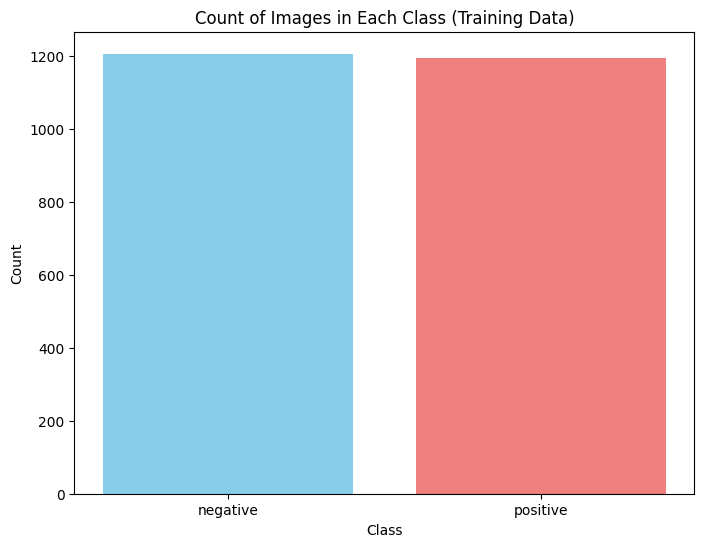

In [4]:
# Get the labels from the training dataset
train_labels = [train_dataset.dataset.labels[i] for i in train_dataset.indices]

# Count the occurrences of each class
from collections import Counter
class_counts = Counter(train_labels)

# Define class names (assuming 0: negative, 1: positive)
class_names = ['negative', 'positive']

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(class_names, [class_counts[0], class_counts[1]], color=['skyblue', 'lightcoral'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Images in Each Class (Training Data)')
plt.show()

In [5]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a simple CNN architecture for binary classification
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512), # Adjust the input size based on your image dimensions after pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create an instance of the SimpleCNN model
model = SimpleCNN(num_classes=2)


# Move the model to the device
model = model.to(device)

print("Custom SimpleCNN model loaded for binary classification.")

Using device: cuda
Custom SimpleCNN model loaded for binary classification.


In [6]:
import torch.optim as optim

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)

print("Loss function (CrossEntropyLoss) and Optimizer (SGD) defined.")

Loss function (CrossEntropyLoss) and Optimizer (SGD) defined.


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Move data to the appropriate device
        X, y = X.to(device), y.to(device)

        # Compute prediction (forward pass)
        pred = model(X)

        # loss function
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= len(dataloader)
    correct /= size
    print(f"Train Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # Set the model to evaluation mode
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []

    with torch.inference_mode(): # Disable gradient calculation for evaluation
        for X, y in dataloader:
            # Move data to the appropriate device
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    correct /= size

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return test_loss # Return the average test loss

print("Train and test loop functions defined.")

Train and test loop functions defined.


In [13]:
# Create DataLoaders for the training and testing datasets
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No need to shuffle test data

epochs = 10 # You can adjust the number of epochs

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.206033  [   32/ 2400]
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.197031 

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.169850 

Accuracy: 0.9333
Precision: 0.9352
Recall: 0.9333
F1-score: 0.9332
Epoch 2
-------------------------------
loss: 0.407030  [   32/ 2400]
Train Error: 
 Accuracy: 92.5%, Avg loss: 0.195696 

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.156419 

Accuracy: 0.9483
Precision: 0.9511
Recall: 0.9483
F1-score: 0.9483
Epoch 3
-------------------------------
loss: 0.232007  [   32/ 2400]
Train Error: 
 Accuracy: 93.8%, Avg loss: 0.166462 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.134998 

Accuracy: 0.9567
Precision: 0.9580
Recall: 0.9567
F1-score: 0.9567
Epoch 4
-------------------------------
loss: 0.061022  [   32/ 2400]
Train Error: 
 Accuracy: 94.4%, Avg loss: 0.159003 

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.124572 

Accuracy: 0.9567
Precision: 0.9567
Recall: 0.9567
F1-score: 0.9567
Epoch 5
------------------------

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have y_true and y_pred from your test loop
# y_true are the true labels and y_pred are the model's predictions

# Example: Using the predictions from the last test loop
# Note: These are the predictions from the last epoch of model_2 training
# You might want to run a separate evaluation after training is complete

# Correctly get the true labels from the test_dataset (which is a Subset)
y_true = [test_dataset.dataset.labels[i] for i in test_dataset.indices]

y_pred = []
model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        pred = model(X)
        y_pred.extend(pred.argmax(1).cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') # Use 'weighted' for multiclass
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")



Accuracy: 0.9717
Precision: 0.9717
Recall: 0.9717
F1-score: 0.9717


In [10]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.9 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [11]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.4


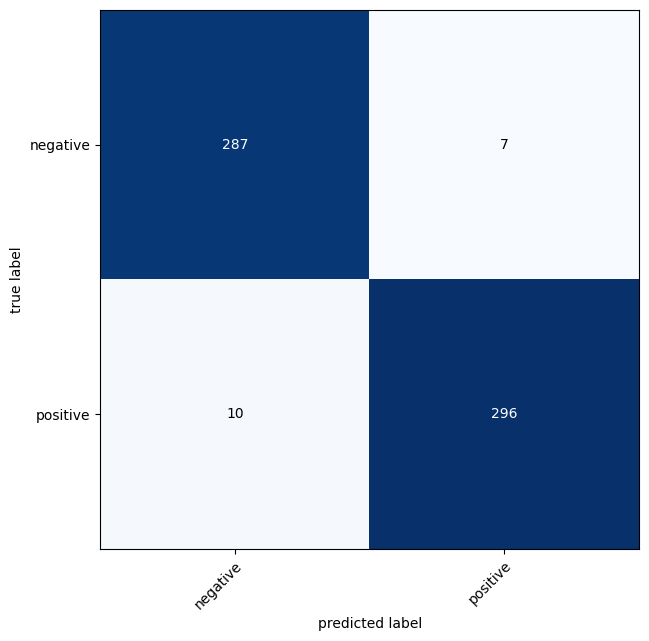

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

# y_pred is already calculated in the previous cell

# Define class names based on your problem (assuming 0: negative, 1: positive)
class_names = ['negative', 'positive']

# 2. Setup confusion matrix instance and compare predictions to targets
# Convert y_true and y_pred to tensors
y_true_tensor = torch.tensor(y_true)
y_pred_tensor = torch.tensor(y_pred)

confmat = ConfusionMatrix(num_classes=len(class_names), task='binary') # Changed task to 'binary' for binary classification
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_true_tensor)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);